In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
from pathlib import Path

# 设置中文字体，防止乱码 (根据你的系统调整，Windows通常是SimHei)
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

class Config:
    # --- 文件路径 ---
    ELEC_FILE = r"E:\A智网\月度电力需求预测报告\0_数据\湖北省行业日用电量_26.1.22.xlsx"
    WEATHER_FILE = r"E:\A智网\月度电力需求预测报告\0_数据\气象.xlsx"
    OUTPUT_DIR = r"E:\A智网\月度电力需求预测报告\1_分析结果\分产业制图" # 输出文件夹
    
    # --- 分析参数 ---
    TARGET_YEAR = 2026
    TARGET_MONTH = 1
    COMPARE_YEAR = 2025 # 通常是去年同期
    
    # --- 筛选行业 (序号: 行业名称) ---
    # 你可以在这里添加或修改你需要分析的行业
    TARGET_INDUSTRIES = {
        1: "客户用电量",
        4: "    第二产业",
        5: "    第三产业",
        6: "B、城乡居民生活用电合计" # 假设序号6是居民，请根据实际情况修改
    }
    
    # --- 单位转换 ---
    UNIT_CONVERSION = 10000 # 万千瓦时 -> 亿千瓦时 (除以10000)

# 确保输出目录存在
if not os.path.exists(Config.OUTPUT_DIR):
    os.makedirs(Config.OUTPUT_DIR)

In [17]:
def load_and_preprocess_data():
    """加载并预处理电量和气象数据"""
    print("正在加载数据...")
    
    # 1. 加载电量数据
    df_elec = pd.read_excel(Config.ELEC_FILE)
    # 将序号设为索引，方便查找
    df_elec.set_index('序号', inplace=True)
    
    # 2. 加载气象数据
    # 跳过第一行(中文表头)，使用第二行(英文表头)作为列名，或者直接指定
    # 根据你的描述，第一行是中文，第二行是英文。pandas默认读第一行。
    # 我们读取时header=1 (即第二行作为列名)，然后重命名方便使用
    df_weather = pd.read_excel(Config.WEATHER_FILE, header=1) 
    # 确保日期列是 datetime 类型
    df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
    # 只需要日期和平均气温
    df_weather = df_weather[['DATE', 'AVG']].rename(columns={'AVG': '平均气温'})
    
    print("数据加载完成。")
    return df_elec, df_weather

def get_month_data(year, month, df_elec, df_weather, industry_name):
    """提取指定年月、指定行业的数据"""
    
    # --- 1. 准备日期范围 ---
    # 构建当月所有可能的日期列名 (电量表格式: YYYYMMDD)
    # 使用 pd.date_range 生成该月所有日期
    dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-{pd.Period(f"{year}-{month}").days_in_month}')
    
    date_cols = [d.strftime('%Y%m%d') for d in dates]
    
    # --- 2. 提取电量数据 ---
    # 找到对应行业的行
    industry_row = df_elec[df_elec['行业名称'] == industry_name]
    
    if industry_row.empty:
        print(f"警告: 未找到行业 {industry_name}")
        return pd.Series(dtype=float)
    
    # 筛选存在的列 (处理未来日期数据不存在的情况)
    valid_cols = [col for col in date_cols if col in industry_row.columns]
    
    # 提取数据并转为 Series，索引为 Day (1, 2, 3...)
    elec_data = industry_row[valid_cols].iloc[0].astype(float)
    elec_data.index = [int(col[-2:]) for col in valid_cols] # 索引改为日 (int)
    
    # 单位转换: 万千瓦时 -> 亿千瓦时
    elec_data = elec_data / Config.UNIT_CONVERSION
    
    # --- 3. 提取气温数据 ---
    # 筛选对应月份的气温
    weather_mask = (df_weather['DATE'].dt.year == year) & (df_weather['DATE'].dt.month == month)
    weather_data = df_weather.loc[weather_mask].set_index('DATE')['平均气温']
    weather_data.index = weather_data.index.day # 索引改为日 (int)
    
    # 截取气温数据，使其长度与电量数据一致 (如果电量数据只到12号，气温也只取到12号用于对齐显示？)
    # 或者气温通常是完整的。根据你的需求，这里我们保留完整气温，但在绘图时对齐。
    # 为了生成Excel表格，我们需要对齐索引。
    
    return elec_data, weather_data

In [18]:
def generate_analysis_excel(df_elec, df_weather):
    """生成分析表格并保存"""
    
    output_path = os.path.join(Config.OUTPUT_DIR, f"{Config.TARGET_YEAR}年{Config.TARGET_MONTH}月_电力气象分析.xlsx")
    writer = pd.ExcelWriter(output_path, engine='openpyxl')
    
    # 获取目标月份的总天数 (用于表头)
    days_in_month = pd.Period(f"{Config.TARGET_YEAR}-{Config.TARGET_MONTH}").days_in_month
    days_index = list(range(1, days_in_month + 1))
    header_days = [f"{Config.TARGET_MONTH}/{d}" for d in days_index]
    
    processed_data_dict = {} # 用于存储处理后的数据供绘图使用
    
    for idx, name in Config.TARGET_INDUSTRIES.items():
        print(f"正在处理行业: {name}...")
        
        # 1. 获取数据
        elec_curr, weather_curr = get_month_data(Config.TARGET_YEAR, Config.TARGET_MONTH, df_elec, df_weather, name)
        elec_prev, weather_prev = get_month_data(Config.COMPARE_YEAR, Config.TARGET_MONTH, df_elec, df_weather, name)
        
        # 2. 构建 DataFrame (行：指标，列：日期)
        # 初始化一个全 NaN 的 DataFrame，列为 1-31 (或30/28)
        df_sheet = pd.DataFrame(index=[
            f"{Config.COMPARE_YEAR}年日售电量",
            f"{Config.TARGET_YEAR}年日售电量",
            f"{Config.COMPARE_YEAR}年平均气温",
            f"{Config.TARGET_YEAR}年平均气温"
        ], columns=days_index)
        
        # 填充数据 (自动对齐索引)
        df_sheet.loc[f"{Config.COMPARE_YEAR}年日售电量"] = elec_prev
        df_sheet.loc[f"{Config.TARGET_YEAR}年日售电量"] = elec_curr
        df_sheet.loc[f"{Config.COMPARE_YEAR}年平均气温"] = weather_prev
        df_sheet.loc[f"{Config.TARGET_YEAR}年平均气温"] = weather_curr
        
        # 修改列名为 1/1, 1/2 ...
        df_sheet.columns = header_days
        
        # 3. 写入 Excel Sheet
        df_sheet.to_excel(writer, sheet_name=name)
        
        # 存储数据用于绘图
        processed_data_dict[name] = df_sheet
        
    writer.close()
    print(f"Excel 文件已保存至: {output_path}")
    return processed_data_dict

In [19]:
def plot_chart(industry_name, df_data):
    """绘制双轴图表 (优化版：左电量右气温，支持负气温，动态调整，大字体)"""
    
    # 提取数据
    days = df_data.columns
    x = range(len(days))
    
    # 提取并确保数据为 float 类型
    elec_prev = df_data.loc[f"{Config.COMPARE_YEAR}年日售电量"].astype(float)
    elec_curr = df_data.loc[f"{Config.TARGET_YEAR}年日售电量"].astype(float)
    temp_prev = df_data.loc[f"{Config.COMPARE_YEAR}年平均气温"].astype(float)
    temp_curr = df_data.loc[f"{Config.TARGET_YEAR}年平均气温"].astype(float)
    
    # --- 1. 设置画布尺寸 ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # 创建右侧 Y 轴 (气温)
    ax2 = ax1.twinx()
    
    # --- 2. 绘制右轴：气温 (柱状图) ---
    bar_width = 0.35
    b1 = ax2.bar([i - bar_width/2 for i in x], temp_prev, width=bar_width, label=f"{Config.COMPARE_YEAR}年平均气温", color='#9ab7e8', alpha=0.6)
    b2 = ax2.bar([i + bar_width/2 for i in x], temp_curr, width=bar_width, label=f"{Config.TARGET_YEAR}年平均气温", color='#f7b686', alpha=0.6)
    
    # 【修改】调大右轴标签字体
    ax2.set_ylabel('平均气温 (℃)', fontsize=16)
    # 【修改】调大右轴刻度字体
    ax2.tick_params(axis='y', labelsize=14)
    
    # --- 动态设置右轴范围 (支持负气温) ---
    valid_temps = pd.concat([temp_prev, temp_curr]).dropna()
    if not valid_temps.empty:
        t_min = valid_temps.min()
        t_max = valid_temps.max()
        y_bottom = min(0, t_min) - (abs(t_min) if t_min < 0 else 5) * 0.2 
        t_span = t_max - y_bottom
        y_top = y_bottom + t_span * 2.5
        ax2.set_ylim(y_bottom, y_top)
        
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    # --- 3. 绘制左轴：电量 (折线图) ---
    ax1.set_zorder(ax2.get_zorder() + 1) 
    ax1.patch.set_visible(False) 
    
    l1, = ax1.plot(x, elec_prev, label=f"{Config.COMPARE_YEAR}年日售电量", color='#2f67b1', marker='s', linewidth=2, markersize=6)
    l2, = ax1.plot(x, elec_curr, label=f"{Config.TARGET_YEAR}年日售电量", color='#ed7d31', marker='^', linewidth=2, markersize=6)
    
    # 【修改】调大左轴标签字体
    ax1.set_ylabel('日售电量（亿千瓦时）', fontsize=16)
    # 【修改】调大左轴刻度字体
    ax1.tick_params(axis='y', labelsize=14)
    
    # --- 动态设置左轴范围 ---
    valid_elec = pd.concat([elec_prev, elec_curr]).dropna()
    if not valid_elec.empty:
        e_min = valid_elec.min()
        e_max = valid_elec.max()
        e_range = e_max - e_min
        if e_range == 0: e_range = e_max * 0.1
        ax1.set_ylim(e_min - e_range * 0.15, e_max + e_range * 0.15)
    
    # --- 4. 美化图表 ---
    ax1.set_xticks(x)
    # 【修改】调大X轴刻度字体
    ax1.set_xticklabels(days, rotation=90, fontsize=14)
    
    # plt.title(f"{industry_name}{Config.TARGET_MONTH}月电量与气温对比", fontsize=16, pad=15)
    
    # 合并图例
    handles = [b1, b2, l1, l2]
    labels = [h.get_label() for h in handles]
    # 【修改】调大图例字体
    plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=12)
    
    ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # 保存
    img_path = os.path.join(Config.OUTPUT_DIR, f"{industry_name}_{Config.TARGET_YEAR}{Config.TARGET_MONTH:02d}.png")
    plt.savefig(img_path, dpi=600)
    plt.show()

正在加载数据...
数据加载完成。
正在处理行业: 客户用电量...
正在处理行业:     第二产业...
正在处理行业:     第三产业...
正在处理行业: B、城乡居民生活用电合计...
Excel 文件已保存至: E:\A智网\月度电力需求预测报告\1_分析结果\分产业制图\2026年1月_电力气象分析.xlsx


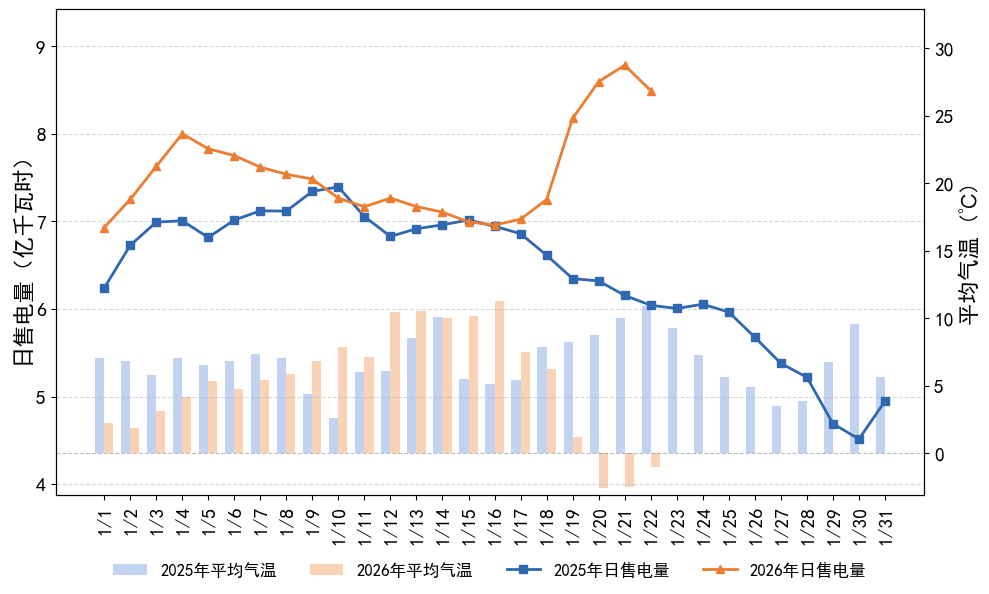

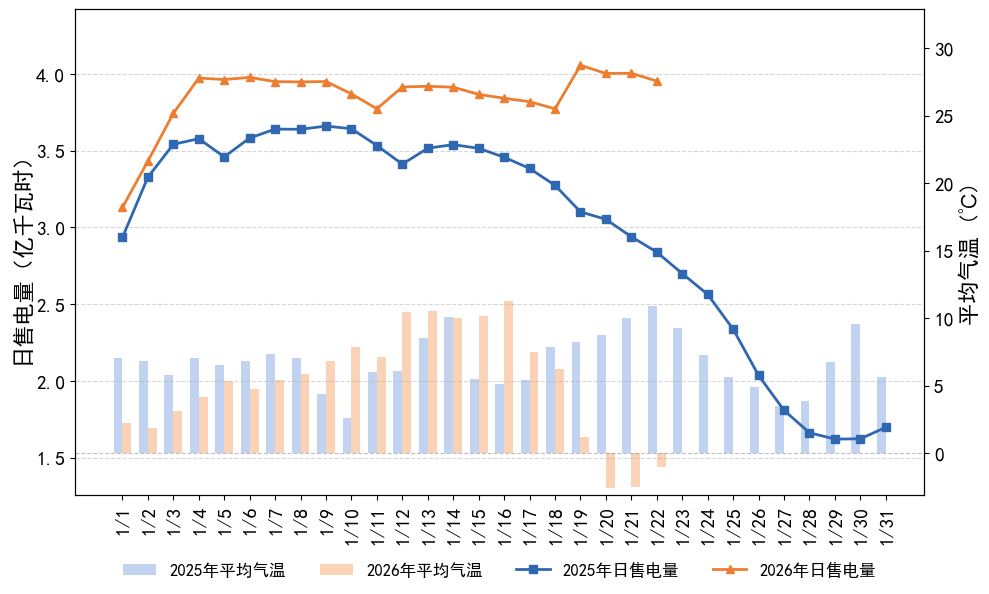

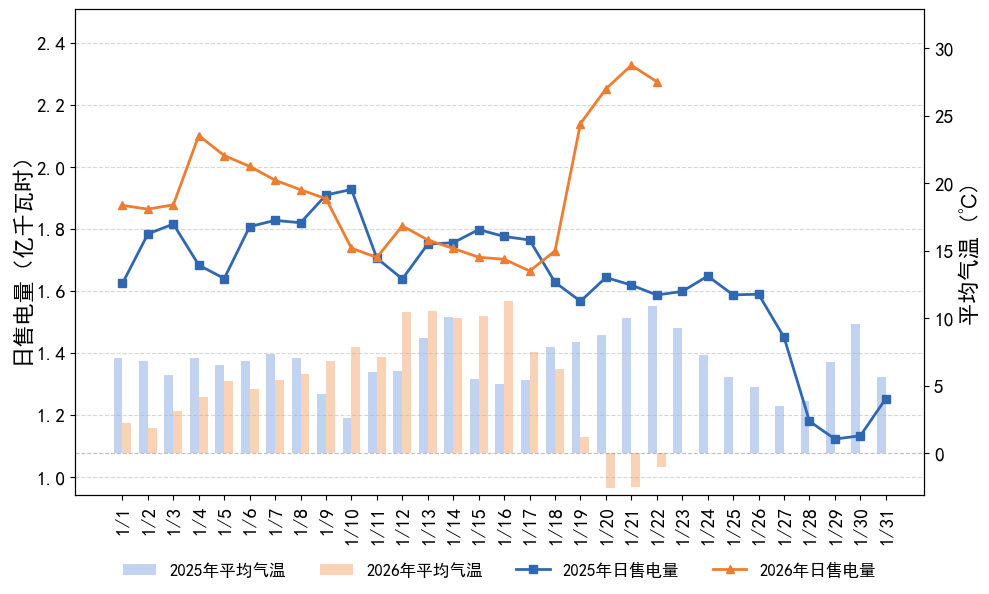

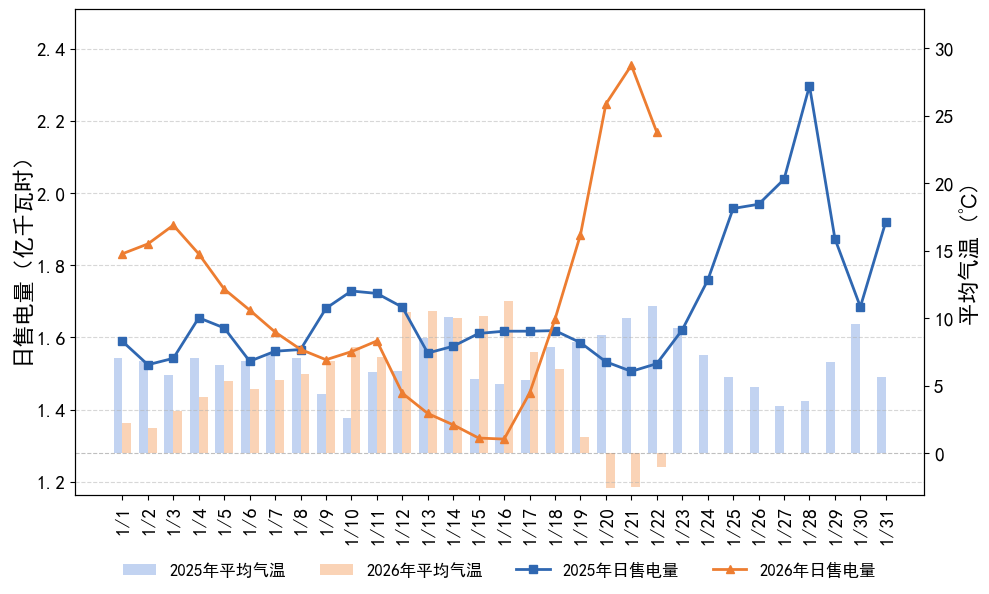

In [20]:
# 1. 加载数据
df_elec, df_weather = load_and_preprocess_data()

# 2. 生成 Excel 并获取处理后的数据
processed_data = generate_analysis_excel(df_elec, df_weather)

# 3. 循环绘图
for name, data in processed_data.items():
    plot_chart(name, data)